# Build 2 – Physics‑Informed vs Data‑Driven Models (updated)

**All requests included – variable names corrected (`laser_spot_size` instead of `spot_diameter`).**

* OLS, XGBoost, PINN ‑ each with and without physics terms  
* Model‑specific feature selection  
* Learning‑curve experiment showing data‑efficiency of physics models  
* Outputs: `model_comparison_metrics.csv`, `learning_curves_build2.csv`, `lc_rmse.png`  

Change `TARGET` near the top to predict a different response variable.

In [1]:
%pip install tensorflow --quiet

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

warnings.filterwarnings('ignore')

# Optional TensorFlow
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False


Note: you may need to restart the kernel to use updated packages.


2025-05-25 07:10:46.538493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748157046.613162    1873 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748157046.633117    1873 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748157046.771770    1873 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748157046.771804    1873 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748157046.771806    1873 computation_placer.cc:177] computation placer alr

In [2]:
DATA_PATH = Path("../data/build2_features.csv")
assert DATA_PATH.exists(), "build2_features.csv not found!"
df = pd.read_csv(DATA_PATH)

In [3]:
df.columns

Index(['layer', 'gas_oxygen', 'top_flow_rate', 'px_class_0', 'px_class_1',
       'total_px', 'absolute_image_capture_timestamp',
       'actual_ventilator_flow_rate', 'bottom_chamber_temperature',
       'bottom_flow_rate', 'bottom_flow_temperature', 'build_chamber_position',
       'build_plate_temperature', 'build_time', 'gas_loop_oxygen',
       'glass_scale_temperature', 'laser_rail_temperature', 'layer_times',
       'module_oxygen', 'powder_chamber_position',
       'target_ventilator_flow_rate', 'top_chamber_temperature',
       'top_flow_temperature', 'ventilator_speed', 'part_id', 'hatch_spacing',
       'laser_beam_power', 'laser_beam_speed', 'laser_module',
       'laser_spot_size', 'parameter_set', 'scan_rotation', 'stripe_width',
       'spatter_px', 'streak_px'],
      dtype='object')

In [4]:
df.head()

,layer,gas_oxygen,top_flow_rate,px_class_0,px_class_1,total_px,absolute_image_capture_timestamp,actual_ventilator_flow_rate,bottom_chamber_temperature,bottom_flow_rate,...,hatch_spacing,laser_beam_power,laser_beam_speed,laser_module,laser_spot_size,parameter_set,scan_rotation,stripe_width,spatter_px,streak_px
0,0,0.001020,97.533620,0,0,0,0.0,39.860813,30.0,39.853672,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0
1,1,0.000960,96.303535,0,0,0,0.0,39.699055,30.0,39.701366,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0
2,2,0.001818,97.156150,0,0,0,0.0,40.015420,30.0,40.001100,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0
3,3,0.001572,97.300950,0,0,0,0.0,40.037292,30.0,40.037500,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0
4,4,0.001136,97.340515,0,0,0,0.0,40.037132,30.0,40.050724,...,110.0,380.0,800.0,1.0,125.0,0,67.0,18.0,0,0


In [ ]:
EXCLUDE = [
    "layer", "part_id", "anomaly_frac",
    "px_class_0", "px_class_1", "total_px",
    "spatter_frac", "streak_frac",
	"layer_times", "build_time",
    "top_flow_rate",
    "glass_scale_temperature",
    "laser_rail_temperature", "parameter_set", "build_chamber_position", 
    "powder_chamber_position",]


df = df.drop(columns=[c for c in EXCLUDE if c in df.columns])
df.columns

Index(['gas_oxygen', 'top_flow_rate', 'absolute_image_capture_timestamp',
       'actual_ventilator_flow_rate', 'bottom_chamber_temperature',
       'bottom_flow_rate', 'bottom_flow_temperature', 'build_chamber_position',
       'build_plate_temperature', 'build_time', 'gas_loop_oxygen',
       'glass_scale_temperature', 'laser_rail_temperature', 'layer_times',
       'module_oxygen', 'powder_chamber_position',
       'target_ventilator_flow_rate', 'top_chamber_temperature',
       'top_flow_temperature', 'ventilator_speed', 'hatch_spacing',
       'laser_beam_power', 'laser_beam_speed', 'laser_module',
       'laser_spot_size', 'parameter_set', 'scan_rotation', 'stripe_width',
       'spatter_px', 'streak_px'],
      dtype='object')

In [6]:
TARGET = "spatter_px"  # change if needed

def add_physics(df):
    out = df.copy()
    # Volumetric Energy Density (uses column hatch_spacing if present)
    hs = out.get("hatch_spacing", 120e-6)
    layer_thick = 50e-6   # 50 µm layer thickness (m)
    out["VED"] = out["laser_beam_power"] / (out["laser_beam_speed"] * hs * layer_thick)
    # Peclet proxy uses laser_spot_size
    out["Peclet"] = out["laser_beam_speed"] * out["laser_spot_size"] / 1.4e-5
    # Simple melt depth proxy
    out["melt_depth"] = np.sqrt(out["VED"]) * 1e-3
    return out

df = add_physics(df)
physics_cols = ["VED","Peclet","melt_depth"]
display(df.head())


,gas_oxygen,top_flow_rate,absolute_image_capture_timestamp,actual_ventilator_flow_rate,bottom_chamber_temperature,bottom_flow_rate,bottom_flow_temperature,build_chamber_position,build_plate_temperature,build_time,...,laser_module,laser_spot_size,parameter_set,scan_rotation,stripe_width,spatter_px,streak_px,VED,Peclet,melt_depth
0,0.001020,97.533620,0.0,39.860813,30.0,39.853672,49.0,0.00,30.0,0.000000,...,1.0,125.0,0,67.0,18.0,0,0,86.363636,7.142857e+09,0.009293
1,0.000960,96.303535,0.0,39.699055,30.0,39.701366,49.0,0.05,30.0,0.093889,...,1.0,125.0,0,67.0,18.0,0,0,86.363636,7.142857e+09,0.009293
2,0.001818,97.156150,0.0,40.015420,30.0,40.001100,49.0,0.10,30.0,0.138333,...,1.0,125.0,0,67.0,18.0,0,0,86.363636,7.142857e+09,0.009293
3,0.001572,97.300950,0.0,40.037292,30.0,40.037500,49.0,0.15,30.0,0.180556,...,1.0,125.0,0,67.0,18.0,0,0,86.363636,7.142857e+09,0.009293
4,0.001136,97.340515,0.0,40.037132,30.0,40.050724,49.0,0.20,30.0,0.224722,...,1.0,125.0,0,67.0,18.0,0,0,86.363636,7.142857e+09,0.009293


In [7]:
df["VED"].unique(), df["Peclet"].unique(), df["melt_depth"].unique()

(array([ 86.36363636,  60.90534979, 103.57142857,  32.22222222]),
 array([7.14285714e+09, 1.25357143e+10, 4.28571429e+09]),
 array([0.0092932 , 0.00780419, 0.010177  , 0.00567646]))

In [8]:
def corr_filter(df,target,thr=0.9):
    """Correlation filter to remove highly correlated features."""

    c=df.drop(columns=[target]).corr().abs()
    drop=set()
    for i in c.columns:
        for j in c.columns:
            if i==j or j in drop: continue
            if c.loc[i,j]>thr:
                if abs(df[i].corr(df[target]))>abs(df[j].corr(df[target])):
                    drop.add(j)
                else:
                    drop.add(i)
    return [col for col in df.drop(columns=[target]).columns if col not in drop]

def vif_filter(X,thr=5):
    """Variance Inflation Factor filter to remove multicollinearity."""
    
    keep=list(X.columns)
    while True:
        v=[variance_inflation_factor(X[keep].values,i) for i in range(len(keep))]
        m=max(v)
        if m>thr:
            keep.pop(v.index(m))
        else: break
    return keep

def select_ols(df,target):
    cols=corr_filter(df,target)
    cols=vif_filter(df[cols])
    lasso=Pipeline([('sc',StandardScaler()),('ls',LassoCV(cv=5,random_state=0))])
    lasso.fit(df[cols],df[target])
    nz=[c for c,coef in zip(cols,lasso.named_steps['ls'].coef_) if coef!=0]
    return nz

def select_xgb(df,target,top=25):
    X=df.drop(columns=[target]); y=df[target]
    mdl=xgb.XGBRegressor(n_estimators=200,max_depth=4,learning_rate=0.1,
                         subsample=0.8,colsample_bytree=0.8,n_jobs=-1, 
                         tree_method="hist", random_state=0)
    mdl.fit(X,y)
    imp=permutation_importance(mdl,X,y,n_repeats=5,random_state=0,n_jobs=-1).importances_mean
    top_cols=pd.Series(imp,index=X.columns).sort_values(ascending=False).head(top).index.tolist()
    return top_cols

def select_pinn(df,target):
    corrs=df.drop(columns=[target]).apply(lambda s: abs(s.corr(df[target])))
    return physics_cols + corrs.sort_values(ascending=False).head(5).index.tolist()


In [9]:
df_clean = df.dropna(axis=1, how="all").copy()
for col in df_clean.columns:
    if df_clean[col].dtype.kind in "O":
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
    if df_clean[col].isna().any():
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

ols_cols = select_ols(train_df, TARGET)
xgb_cols = select_xgb(train_df, TARGET)
pinn_cols = select_pinn(train_df, TARGET)

print("OLS columns:", ols_cols)
print("XGB columns:", xgb_cols)
print("PINN columns:", pinn_cols)

OLS columns: ['bottom_flow_rate', 'gas_loop_oxygen', 'glass_scale_temperature', 'laser_rail_temperature', 'layer_times', 'laser_beam_power', 'laser_spot_size', 'stripe_width', 'streak_px']
XGB columns: ['layer_times', 'build_chamber_position', 'streak_px', 'build_time', 'bottom_chamber_temperature', 'bottom_flow_rate', 'ventilator_speed', 'gas_oxygen', 'top_flow_rate', 'module_oxygen', 'bottom_flow_temperature', 'actual_ventilator_flow_rate', 'top_chamber_temperature', 'top_flow_temperature', 'glass_scale_temperature', 'powder_chamber_position', 'gas_loop_oxygen', 'laser_beam_speed', 'build_plate_temperature', 'hatch_spacing', 'laser_rail_temperature', 'absolute_image_capture_timestamp', 'laser_beam_power', 'target_ventilator_flow_rate', 'laser_module']
PINN columns: ['VED', 'Peclet', 'melt_depth', 'layer_times', 'build_time', 'powder_chamber_position', 'build_chamber_position', 'ventilator_speed']


In [10]:
# -----------------------------------------------------------
# 1 – simple Pearson correlation with the target
# -----------------------------------------------------------
corr = (
    train_df[xgb_cols + ["spatter_px"]]
    .corr()["spatter_px"]
    .drop("spatter_px")
    .sort_values(ascending=False)        # high → low
)

print(corr.head(10))


layer_times                    0.967605
laser_beam_speed               0.809130
top_flow_rate                  0.791919
glass_scale_temperature        0.659557
laser_rail_temperature         0.223472
bottom_flow_rate               0.047174
actual_ventilator_flow_rate    0.035644
laser_beam_power              -0.108903
top_chamber_temperature       -0.530420
module_oxygen                 -0.559562
Name: spatter_px, dtype: float64


In [11]:
print(TF_AVAILABLE)

True


In [12]:
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

metrics = []

# OLS
for phys in [False, True]:
    cols = ols_cols + (physics_cols if phys else [])
    pipe = Pipeline([('sc', StandardScaler()), ('ols', LinearRegression())])
    pipe.fit(train_df[cols], train_df[TARGET])
    pred = pipe.predict(test_df[cols])
    metrics.append(dict(model='OLS+phys' if phys else 'OLS',
                        rmse=rmse(test_df[TARGET], pred),
                        r2=r2_score(test_df[TARGET], pred)))

# XGB
for phys in [False, True]:
    cols = xgb_cols + (physics_cols if phys else [])
    mdl = xgb.XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.05,
                          subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=0, tree_method="hist")
    mdl.fit(train_df[cols], train_df[TARGET])
    pred = mdl.predict(test_df[cols])
    metrics.append(dict(model='XGB+phys' if phys else 'XGB',
                        rmse=rmse(test_df[TARGET], pred),
                        r2=r2_score(test_df[TARGET], pred)))


    def build_mlp(input_dim: int) -> tf.keras.Model:
        m = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(64,  activation="relu"),
            layers.Dense(1),
        ])
        m.compile(optimizer="adam", loss="mse")
        return m

# MLP
mlp_cols        = [c for c in pinn_cols if c not in physics_cols]   # drop physics
scaler_mlp      = StandardScaler()
X_train_mlp     = scaler_mlp.fit_transform(train_df[mlp_cols])
X_test_mlp      = scaler_mlp.transform(test_df[mlp_cols])

mlp_model       = build_mlp(X_train_mlp.shape[1])
mlp_model.fit(X_train_mlp, train_df[TARGET],
            epochs=50, batch_size=256, verbose=0)

pred            = mlp_model.predict(X_test_mlp).ravel()
# MLP result
metrics.append({
    "model": "MLP",
    "rmse":  rmse(test_df[TARGET], pred),
    "r2":    r2_score(test_df[TARGET], pred),
})


# PINN
cols      = pinn_cols
ved_idx   = cols.index("VED")
scaler = StandardScaler()
X_train   = scaler.fit_transform(train_df[cols]).astype(np.float32)
X_test    = scaler.transform(test_df[cols]).astype(np.float32)
y_train   = train_df[TARGET].values.astype(np.float32)

pinn = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64,  activation="relu"),
    layers.Dense(1),
])

optimizer     = tf.keras.optimizers.Adam()   # <— now defined
lambda_phys   = 10e-2  # physics penalty coefficient
epochs        = 50
batch_size    = 256
dataset       = (
    tf.data.Dataset
      .from_tensor_slices((X_train, y_train))
      .shuffle(len(X_train))
      .batch(batch_size)
)

for epoch in range(epochs):
    for x_batch, y_batch in dataset:
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_batch)
            y_pred        = pinn(x_batch, training=True)
            mse           = tf.keras.losses.mse(y_batch, tf.squeeze(y_pred))
            grad          = tape.gradient(y_pred, x_batch)[:, ved_idx]
            phys_penalty  = tf.nn.relu(grad)
            loss          = tf.reduce_mean(mse) + lambda_phys * tf.reduce_mean(phys_penalty)
        grads = tape.gradient(loss, pinn.trainable_variables)
        optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
        del tape

pred = pinn(X_test).numpy().ravel()
metrics.append({
    "model": "PINN",
    "rmse":  rmse(test_df[TARGET], pred),
    "r2":    r2_score(test_df[TARGET], pred),
})

2025-05-25 07:11:07.266076: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [13]:
results=pd.DataFrame(metrics).sort_values('rmse')
display(results)
results.to_csv("model_comparison_metrics.csv",index=False)


,model,rmse,r2
2,XGB,19701.415178,0.984303
3,XGB+phys,19729.502781,0.984258
5,PINN,38587.752668,0.939783
1,OLS+phys,39868.184162,0.935720
0,OLS,39868.184162,0.935720
4,MLP,48886.493840,0.903351


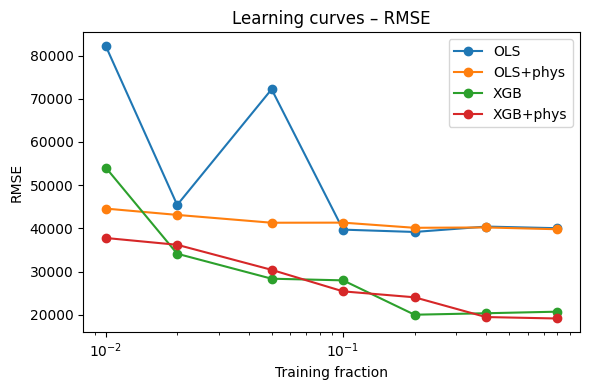

In [14]:
fractions=[0.01,0.02,0.05,0.1,0.2,0.4,0.8]
rng=np.random.default_rng(0)
lc=[]
def eval(cols,model_fn,label):
    Xtest=test_df[cols]; ytest=test_df[TARGET]
    for f in fractions:
        n=int(f*len(train_df))
        idx=rng.choice(train_df.index,n,replace=False)
        Xt=train_df.loc[idx,cols]; yt=train_df.loc[idx,TARGET]
        m=model_fn(); m.fit(Xt,yt)
        pred=m.predict(Xtest)
        lc.append(dict(model=label,frac=f,rmse=rmse(ytest,pred),
                       r2=r2_score(ytest,pred)))

def make_ols(): return Pipeline([('sc',StandardScaler()),('ols',LinearRegression())])
def make_xgb(): return xgb.XGBRegressor(n_estimators=300,max_depth=4,learning_rate=0.1,
                                        subsample=0.8,colsample_bytree=0.8,
                                        n_jobs=-1,random_state=0, tree_method="hist")

eval(ols_cols,make_ols,'OLS')
eval(ols_cols+physics_cols,make_ols,'OLS+phys')
eval(xgb_cols,make_xgb,'XGB')
eval(xgb_cols+physics_cols,make_xgb,'XGB+phys')

lc_df=pd.DataFrame(lc)
lc_df.to_csv("learning_curves_build2.csv",index=False)

plt.figure(figsize=(6,4))
for m in lc_df.model.unique():
    g=lc_df[lc_df.model==m]
    plt.plot(g.frac,g.rmse,marker='o',label=m)
plt.xscale('log'); plt.xlabel('Training fraction'); plt.ylabel('RMSE')
plt.title('Learning curves – RMSE'); plt.legend(); plt.tight_layout()
plt.savefig("lc_rmse.png",dpi=150)
plt.show()


  0%|          | 0/200 [00:00<?, ?it/s]

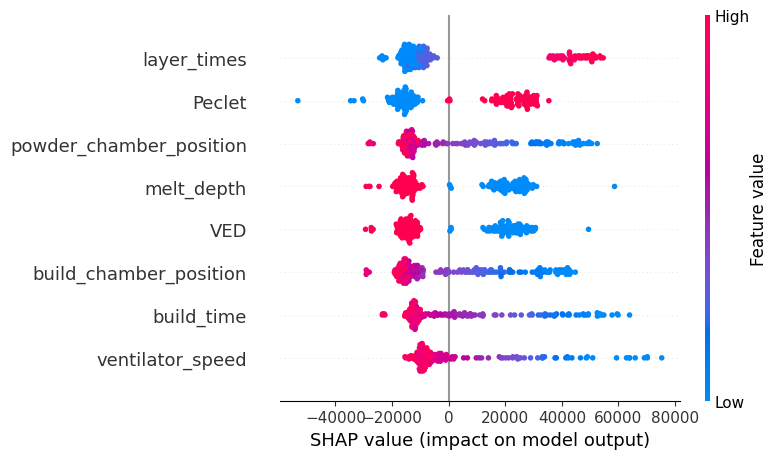

In [15]:
import shap

# 1) pick a small “background” sample from your PINN inputs
#    (here we sample 100 points at random to estimate expectations)
bg_idx = np.random.choice(X_train.shape[0], 100, replace=False)
background = X_train[bg_idx]

# 2) wrap your model.predict in a function that returns numpy preds
def pinn_predict(x: np.ndarray) -> np.ndarray:
    # x should be of shape (n_samples, n_features)
    return pinn(x.astype(np.float32)).numpy().ravel()

# 3) build a SHAP explainer
explainer = shap.KernelExplainer(pinn_predict, background)

# 4) compute SHAP values on a subset of your test set (for speed)
X_test_sub = X_test[:200]  
shap_values = explainer.shap_values(X_test_sub, nsamples=200)

# 5) plot a summary plot
shap.summary_plot(
    shap_values, 
    X_test_sub, 
    feature_names=pinn_cols, 
    show=False,
)

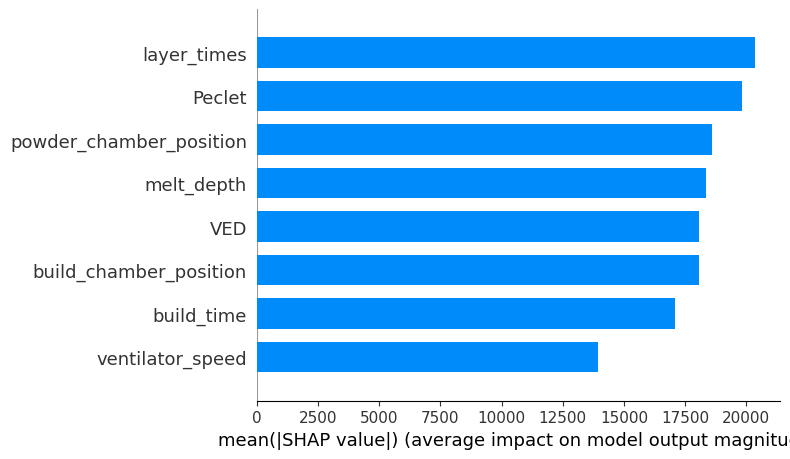

In [17]:
# bar plot of mean(|SHAP|)
shap.summary_plot(shap_values, X_test_sub, feature_names=pinn_cols, plot_type="bar", show=False)

In [18]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[0], 
    X_test_sub[0], 
    feature_names=pinn_cols
)

TypeError: Object of type EagerTensor is not JSON serializable